# <font color='red' style='font-size: 25px;'>Interpretação de Ensaio Triaxial Não Drenado  </font>

# <font color='red' style='font-size: 25px;'>Consolidated Undrained Triaxial Test - CIU  </font>
<hr style='border: 2px solid red;'>

Este `script` recebe os arquivos de dados de laboratório referentes à moldagem, saturação (percolação e contrapressão), adensamento isotrópico
e da fase de cisalhamento.  Processa os cálculos necessários à interpretação do ensaio e à definição dos parâmetros de resistência do solo.

Para cada corpo de prova do ensaio, devem ser preparados os arquivos de dados. São fornecidos: arquivo com os dados da fase de moldagem e arquivo com dados da fase de cisalhamento, ambos no formato .csv. Após o processamento, o script gera os arquivos com os dados calculados, que podem ser exportados para o Excel. Para todas as fases do ensaio, são geradas tabelas formatadas, constantes no script, que podem ser copiadas e levadas para os relatórios técnicos.

São apresentadas as curvas: tensão versus deformação axial, poropressão versus deformação axial, trajetória de tensões, envoltórias de resistência (máxima tensão de desvio e máxima obliquidade) e o gráfico com os Circulos de Mohr.

A envoltória de resistência dos Círculos de Mohr é obtida ajustando os valores de c (coesão) e phi (ângulo de atrito) até obter a melhor reta tangente aos círculos. Ajusta-se, também a variável `sig` que controla o intervalo de tensões para o traçado da envoltória. `As instruções estão no item Traçado da Envoltória de Mohr-Coulomb.`

`Preparado por: Eng. José Mário Queiroga Mafra`

Outubro/2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# <font color='green' style='font-size: 20px;'>Funções utilizadas no script</font>
<hr style='border: 2px solid green;'>

In [2]:
def moldagem_cp(df, label=None):
    
    '''Esta função recebe os dados de moldagem do corpo de prova e processa os cálculos complementares'''
    
    df = df.copy()
    df['Área_Inicial (cm²)'] = (np.pi * df['Diâmetro (cm)'] ** 2 / 4).round(2)  
    df['Volume_Inicial (cm³)'] = (df['Área_Inicial (cm²)'] * df['Altura (cm)']).round(2)
    df['Massa Esp Úmida (g/cm³)'] = (df['Massa Úmida (g)'] / df['Volume_Inicial (cm³)']).round(2)
    df['Massa Seca (g)'] = (df['Massa Úmida (g)'] / (1 + (df['Umidade (%)'] / 100))).round(2)
    df['Massa Esp Seca (g/cm³)']= (df['Massa Seca (g)'] / df['Volume_Inicial (cm³)']).round(2)
    df['Peso Esp Sólidos (kN/m³)'] = (df['Gs'] * df['Peso Esp Água (kN/m³)']).round(2)
    df['Peso Esp Seco (kN/m³)'] = ((df['Massa Seca (g)'] / df['Volume_Inicial (cm³)']) * df['Peso Esp Água (kN/m³)']).round(2)
    df['Índice de Vazios'] = ((df['Peso Esp Sólidos (kN/m³)'] / df['Peso Esp Seco (kN/m³)']) - 1).round(3)
    df['Saturação (%)'] = (df['Peso Esp Sólidos (kN/m³)'] * df['Umidade (%)'] / (df['Índice de Vazios'] * df['Peso Esp Água (kN/m³)'])).round(2)
    
    X = df[['Área_Inicial (cm²)','Volume_Inicial (cm³)','Massa Esp Úmida (g/cm³)','Massa Seca (g)',
           'Massa Esp Seca (g/cm³)','Peso Esp Sólidos (kN/m³)','Peso Esp Seco (kN/m³)','Índice de Vazios',
           'Saturação (%)']]
  
    if label:
        y = df[label]
        return X,y
    return X

In [3]:
def saturacao_percolacao(df, data_1):
    
    '''Esta função recebe os dados da fase de saturação do corpo de prova por percolação, processa os cálculos
       complementares e retorna um dataframe com o resumo dos dados'''
        
    linhas_1 = ['Há Variação de Volume ?','Valor da Variação de Volume','Volume Final do CP (cm³)','Massa Esp Seca (g/cm³)','Índice de Vazios após Percolação', 'Saturação']
   

    X = pd.DataFrame(data=data_1,index=linhas_1)
    return X

In [4]:
def saturacao_contrapressao(df, data_2):
    
    '''Esta função recebe os dados da fase de saturação do corpo de prova por contrapressão, processa os cálculos
       complementares e retorna um dataframe com o resumo dos dados'''
   
    linhas_2 = ['Há Variação de Volume ?','Valor da Variação de Volume','Volume Final do CP (cm³)','Massa Esp Seca (g/cm³)','Índice de Vazios após Saturação', 'Saturação', 'Contra pressão final (kPa)','Parâmetro B']
    
    X = pd.DataFrame(data=data_2,index=linhas_2)  
    
    return X

In [5]:
def adensamento(df,Variação_de_Volume):
    
    '''Esta função recebe os dados de adensamento do corpo de prova, processa os cálculos complementares 
       e retorna um dataframe com o resumo dos dados de adensamento.'''
    
    
    Volume_final = df['Volume_Inicial (cm³)'][0] - Variação_de_Volume
    Massa_Esp_Seca_Final = df['Massa Seca (g)'][0] / Volume_final
    Variação_de_Altura = df['Altura (cm)'][0] * Variação_de_Volume / (3 * df['Volume_Inicial (cm³)'][0])
    Altura_Final = df['Altura (cm)'][0] - Variação_de_Altura
    Área_Final  = Volume_final  / Altura_Final
    Índice_de_Vazios_após_Adensamento = (df['Gs'][0]/ Massa_Esp_Seca_Final) - 1



    linhas_3 = ['Há Variação de Volume ?','Valor da Variação de Volume (cm³)',
                'Volume Final do CP (cm³)',
                'Massa Esp Seca Final (g/cm³)','Variação de altura (cm)', 'Altura final do CP (cm)','Área Final (cm²)',
                'Índice de Vazios após Adensamento']

    data_3 = {'Valores Calculados':['Sim', Variação_de_Volume, Volume_final,Massa_Esp_Seca_Final,
                                    Variação_de_Altura, Altura_Final,Área_Final,Índice_de_Vazios_após_Adensamento]}


    Y = pd.DataFrame(data=data_3,index=linhas_3)
    return Y

In [6]:
def deformacao_percent(df):
    
    '''Esta função recebe dados de deformação axial e deformação volumétrica do arquivo de cisalhamento do corpo
       de prova e retorna as deformações percentuais, Sigma_d e Sigma_3 '''
    
    df['Deform_axial'] = df['Deform_axial'] * 100
    df.rename(columns={'Deform_axial': "Deform_axial_(%)"}, inplace=True)

    return df

In [7]:
def cisalhamento(df, label=None):
    
    '''Esta função recebe dados de cisalhamento do corpo de prova, processa cálculos complementares e retorna
       um dataframe com o resumo dos dados.'''
    
    df = df.copy()
    df['Sigma_1_(kPa)'] = df['Sigma_d_(kPa)'] + df['Sigma_3_(kPa)']
    df["Sigma'_1_(kPa)"] = df['Sigma_1_(kPa)'] - df['Delta_U_(kPa)']
    df["Sigma3'_(kPa)"] = df['Sigma_3_(kPa)'] - df['Delta_U_(kPa)']
    df["Sigma'_1/Sigma'_3"] = (df["Sigma'_1_(kPa)"] / df["Sigma3'_(kPa)"]).round(2)
    df['t']= (df['Sigma_1_(kPa)'] - df['Sigma_3_(kPa)']) /2
    df['s'] = (df['Sigma_1_(kPa)'] + df['Sigma_3_(kPa)']) / 2
    df["s'"] = (df["Sigma'_1_(kPa)"] + df["Sigma3'_(kPa)"]) / 2
    df['q'] = df['Sigma_d_(kPa)']
    df['p'] = (df['Sigma_1_(kPa)'] + 2 * df['Sigma_3_(kPa)']) / 3
    df["p'"] = (df["Sigma'_1_(kPa)"] + 2 * df["Sigma3'_(kPa)"])/3
          
    Z = df[['Sigma_1_(kPa)',"Sigma'_1_(kPa)","Sigma3'_(kPa)","Sigma'_1/Sigma'_3",'t','s',"s'",'q','p',"p'"]]

    if label:
            w = df[label]
            return Z,w
    return Z

### 1. CORPO DE PROVA CP-1  50 kPa

In [8]:
moldagem = pd.read_csv('moldagem_cp_1.csv',sep=';')
moldagem

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³)
0,11.84,5.01,417.88,20.6,3.27,9.81


Moldagem

In [9]:
# Chamando a função moldagem_cp

X, y = moldagem_cp(moldagem ,label= ['Altura (cm)','Diâmetro (cm)','Massa Úmida (g)','Umidade (%)','Gs','Peso Esp Água (kN/m³)'])

df_final = pd.concat([y,X],axis=1)

In [10]:
df_final
df_final.rename(index={0: 'Valores'}, inplace=True)
df_final

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³),Área_Inicial (cm²),Volume_Inicial (cm³),Massa Esp Úmida (g/cm³),Massa Seca (g),Massa Esp Seca (g/cm³),Peso Esp Sólidos (kN/m³),Peso Esp Seco (kN/m³),Índice de Vazios,Saturação (%)
Valores,11.84,5.01,417.88,20.6,3.27,9.81,19.71,233.37,1.79,346.5,1.48,32.08,14.57,1.202,56.04


In [11]:
# Tabela de Moldagem do corpo de prova CP_1

df_final.T.round(2)


,Valores
Altura (cm),11.84
Diâmetro (cm),5.01
Massa Úmida (g),417.88
Umidade (%),20.60
Gs,3.27
Peso Esp Água (kN/m³),9.81
Área_Inicial (cm²),19.71
Volume_Inicial (cm³),233.37
Massa Esp Úmida (g/cm³),1.79
Massa Seca (g),346.50


Saturação

In [12]:
# Chamando a função saturacao_percolacao

saturacao_percolacao(df_final, data_1 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                               df_final['Massa Esp Seca (g/cm³)'][0], 
                                                               df_final['Índice de Vazios'][0],
                                                               df_final['Saturação (%)'][0]]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),233.37
Massa Esp Seca (g/cm³),1.48
Índice de Vazios após Percolação,1.202
Saturação,56.04


In [13]:
# Chamando a função saturacao_contrapressao

saturacao_contrapressao(df_final, data_2 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                                  df_final['Massa Esp Seca (g/cm³)'][0],
                                                                  df_final['Índice de Vazios'][0],
                                                                  df_final['Saturação (%)'][0], 240, 0.999]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),233.37
Massa Esp Seca (g/cm³),1.48
Índice de Vazios após Saturação,1.202
Saturação,56.04
Contra pressão final (kPa),240
Parâmetro B,0.999


Adensamento

In [14]:
# Chamando a função adensamento

adensamento(df_final,2.3)

,Valores Calculados
Há Variação de Volume ?,Sim
Valor da Variação de Volume (cm³),2.3
Volume Final do CP (cm³),231.07
Massa Esp Seca Final (g/cm³),1.499546
Variação de altura (cm),0.038897
Altura final do CP (cm),11.801103
Área Final (cm²),19.580373
Índice de Vazios após Adensamento,1.180661


Cisalhamento

In [15]:
cp_1 = pd.read_csv('cisalhamento_cp1.csv', sep=';')
cp_1.head()

,Deform_axial,Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa)
0,0.00000,0.0,0.000,50
1,0.00216,2.2,52.918,50
2,0.00675,11.2,68.576,50
3,0.01600,23.7,95.506,50
4,0.02529,28.9,109.234,50


In [16]:
# Chamando a função deformacao_percent

deformacao_percent(cp_1)

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa)
0,0.000,0.0,0.000,50
1,0.216,2.2,52.918,50
2,0.675,11.2,68.576,50
3,1.600,23.7,95.506,50
4,2.529,28.9,109.234,50
5,3.457,31.8,120.752,50
6,4.621,33.1,132.657,50
7,5.320,34.3,136.422,50
8,6.247,32.8,143.530,50
9,6.948,32.3,145.249,50


In [17]:
# Chamando a função cisalhamento

Z, w = cisalhamento(cp_1 ,label= ['Deform_axial_(%)','Delta_U_(kPa)','Sigma_d_(kPa)','Sigma_3_(kPa)'])

In [18]:
df_final = pd.concat([w,Z],axis=1)

In [19]:
df_final.head()

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.000,0.0,0.000,50,50.000,50.000,50.0,1.00,0.000,50.000,50.000,0.000,50.000000,50.000000
1,0.216,2.2,52.918,50,102.918,100.718,47.8,2.11,26.459,76.459,74.259,52.918,67.639333,65.439333
2,0.675,11.2,68.576,50,118.576,107.376,38.8,2.77,34.288,84.288,73.088,68.576,72.858667,61.658667
3,1.600,23.7,95.506,50,145.506,121.806,26.3,4.63,47.753,97.753,74.053,95.506,81.835333,58.135333
4,2.529,28.9,109.234,50,159.234,130.334,21.1,6.18,54.617,104.617,75.717,109.234,86.411333,57.511333


#### CP1_50 - Tabela Preparada para Traçado dos Gráficos e salvada no arquivo cp1_50_calculado

In [20]:
df_final.to_csv('cp1_50_calculado.csv', index=False)

### 2.  CORPO DE PROVA CP-2 100 kPa

In [21]:
moldagem = pd.read_csv('moldagem_cp_2.csv',sep=';')
moldagem

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³)
0,12,4.99,431.36,20.3,3.27,9.81


Moldagem

In [22]:
X, y = moldagem_cp(moldagem ,label= ['Altura (cm)','Diâmetro (cm)','Massa Úmida (g)','Umidade (%)','Gs','Peso Esp Água (kN/m³)'])

df_final = pd.concat([y,X],axis=1)

In [23]:
df_final
df_final.rename(index={0: 'Valores'}, inplace=True)
df_final

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³),Área_Inicial (cm²),Volume_Inicial (cm³),Massa Esp Úmida (g/cm³),Massa Seca (g),Massa Esp Seca (g/cm³),Peso Esp Sólidos (kN/m³),Peso Esp Seco (kN/m³),Índice de Vazios,Saturação (%)
Valores,12,4.99,431.36,20.3,3.27,9.81,19.56,234.72,1.84,358.57,1.53,32.08,14.99,1.14,58.23


In [24]:
# Tabela de Moldagem do corpo de prova CP_2

df_final.T.round(2)

,Valores
Altura (cm),12.00
Diâmetro (cm),4.99
Massa Úmida (g),431.36
Umidade (%),20.30
Gs,3.27
Peso Esp Água (kN/m³),9.81
Área_Inicial (cm²),19.56
Volume_Inicial (cm³),234.72
Massa Esp Úmida (g/cm³),1.84
Massa Seca (g),358.57


Saturação

In [25]:
# Chamando a função saturacao_percolacao

saturacao_percolacao(df_final, data_1 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                               df_final['Massa Esp Seca (g/cm³)'][0],
                                                               df_final['Índice de Vazios'][0],
                                                               df_final['Saturação (%)'][0]]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),234.72
Massa Esp Seca (g/cm³),1.53
Índice de Vazios após Percolação,1.14
Saturação,58.23


In [26]:
# Chamando a função saturacao_contrapressao

saturacao_contrapressao(df_final, data_2 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                                  df_final['Massa Esp Seca (g/cm³)'][0],
                                                                  df_final['Índice de Vazios'][0],
                                                                  df_final['Saturação (%)'][0], 240, 0.98]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),234.72
Massa Esp Seca (g/cm³),1.53
Índice de Vazios após Saturação,1.14
Saturação,58.23
Contra pressão final (kPa),240
Parâmetro B,0.98


Adensamento

In [27]:
# Chamando a função adensamento

adensamento(df_final,2.5)

,Valores Calculados
Há Variação de Volume ?,Sim
Valor da Variação de Volume (cm³),2.5
Volume Final do CP (cm³),232.22
Massa Esp Seca Final (g/cm³),1.544096
Variação de altura (cm),0.042604
Altura final do CP (cm),11.957396
Área Final (cm²),19.420616
Índice de Vazios após Adensamento,1.117744


Cisalhamento

In [28]:
cp_2 = pd.read_csv('cisalhamento_cp2.csv', sep=';')
cp_2.head()

,Deform_axial,Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa)
0,0.0000,0.0,0.000,100
1,0.0018,4.1,58.995,100
2,0.0062,8.5,78.613,100
3,0.0152,16.6,121.784,100
4,0.0242,28.0,145.505,100


In [29]:
# Chamando a função deformacao_percent

deformacao_percent(cp_2)

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa)
0,0.00,0.0,0.000,100
1,0.18,4.1,58.995,100
2,0.62,8.5,78.613,100
3,1.52,16.6,121.784,100
4,2.42,28.0,145.505,100
5,3.33,39.1,164.367,100
6,4.47,53.8,179.797,100
7,5.16,59.9,185.397,100
8,6.08,66.2,192.138,100
9,6.76,68.7,195.835,100


In [30]:
# Chamando a função cisalhamento

Z, w = cisalhamento(cp_2 ,label= ['Deform_axial_(%)','Delta_U_(kPa)','Sigma_d_(kPa)','Sigma_3_(kPa)'])

In [31]:
df_final = pd.concat([w,Z],axis=1)

In [32]:
df_final.head()

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.00,0.0,0.000,100,100.000,100.000,100.0,1.00,0.0000,100.0000,100.0000,0.000,100.000000,100.000000
1,0.18,4.1,58.995,100,158.995,154.895,95.9,1.62,29.4975,129.4975,125.3975,58.995,119.665000,115.565000
2,0.62,8.5,78.613,100,178.613,170.113,91.5,1.86,39.3065,139.3065,130.8065,78.613,126.204333,117.704333
3,1.52,16.6,121.784,100,221.784,205.184,83.4,2.46,60.8920,160.8920,144.2920,121.784,140.594667,123.994667
4,2.42,28.0,145.505,100,245.505,217.505,72.0,3.02,72.7525,172.7525,144.7525,145.505,148.501667,120.501667


#### CP2_100 - Tabela Preparada para Traçado dos Gráficos e salvada no arquivo cp2_100_calculado

In [33]:
df_final.to_csv('cp2_100_calculado.csv', index=False)

### 3.  CORPO DE PROVA CP-3 250 kPa

In [34]:
moldagem = pd.read_csv('moldagem_cp_3.csv',sep=';')
moldagem

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³)
0,11.21,5.02,387.62,19.1,3.27,9.81


Moldagem

In [35]:
# Chamando a função moldagem_cp

X, y = moldagem_cp(moldagem ,label= ['Altura (cm)','Diâmetro (cm)','Massa Úmida (g)','Umidade (%)','Gs','Peso Esp Água (kN/m³)'])

df_final = pd.concat([y,X],axis=1)

In [36]:
df_final
df_final.rename(index={0: 'Valores'}, inplace=True)
df_final

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³),Área_Inicial (cm²),Volume_Inicial (cm³),Massa Esp Úmida (g/cm³),Massa Seca (g),Massa Esp Seca (g/cm³),Peso Esp Sólidos (kN/m³),Peso Esp Seco (kN/m³),Índice de Vazios,Saturação (%)
Valores,11.21,5.02,387.62,19.1,3.27,9.81,19.79,221.85,1.75,325.46,1.47,32.08,14.39,1.229,50.82


In [37]:
# Tabela de Moldagem do corpo de prova CP_3

df_final.T.round(2)

,Valores
Altura (cm),11.21
Diâmetro (cm),5.02
Massa Úmida (g),387.62
Umidade (%),19.10
Gs,3.27
Peso Esp Água (kN/m³),9.81
Área_Inicial (cm²),19.79
Volume_Inicial (cm³),221.85
Massa Esp Úmida (g/cm³),1.75
Massa Seca (g),325.46


Saturação

In [38]:
# Chamando a função saturacao_percolacao

saturacao_percolacao(df_final, data_1 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                               df_final['Massa Esp Seca (g/cm³)'][0],
                                                               df_final['Índice de Vazios'][0],
                                                               df_final['Saturação (%)'][0]]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),221.85
Massa Esp Seca (g/cm³),1.47
Índice de Vazios após Percolação,1.229
Saturação,50.82


In [39]:
# Chamando a função saturacao_contrapressao

saturacao_contrapressao(df_final, data_2 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                                  df_final['Massa Esp Seca (g/cm³)'][0],
                                                                  df_final['Índice de Vazios'][0],
                                                                  df_final['Saturação (%)'][0], 240, 0.980]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),221.85
Massa Esp Seca (g/cm³),1.47
Índice de Vazios após Saturação,1.229
Saturação,50.82
Contra pressão final (kPa),240
Parâmetro B,0.98


Adensamento

In [40]:
# Chamando a função adensamento

adensamento(df_final,11.9)

,Valores Calculados
Há Variação de Volume ?,Sim
Valor da Variação de Volume (cm³),11.9
Volume Final do CP (cm³),209.95
Massa Esp Seca Final (g/cm³),1.550179
Variação de altura (cm),0.200434
Altura final do CP (cm),11.009566
Área Final (cm²),19.06978
Índice de Vazios após Adensamento,1.109434


Cisalhamento

In [41]:
cp_3 = pd.read_csv('cisalhamento_cp3.csv', sep=';')
cp_3.head()

,Deform_axial,Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa)
0,0.0000,0.0,0.000,250
1,0.0019,8.2,116.078,250
2,0.0059,23.6,209.725,250
3,0.0148,62.5,294.047,250
4,0.0244,104.9,312.254,250


In [42]:
# Chamando a função deformacao_percent

deformacao_percent(cp_3)

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa)
0,0.00,0.0,0.000,250
1,0.19,8.2,116.078,250
2,0.59,23.6,209.725,250
3,1.48,62.5,294.047,250
4,2.44,104.9,312.254,250
5,3.43,139.3,321.002,250
6,4.69,174.9,323.700,250
7,5.45,182.2,315.276,250
8,6.46,187.7,311.909,250
9,7.22,190.5,309.387,250


In [43]:
# Chamando a função cisalhamento

Z, w = cisalhamento(cp_3 ,label= ['Deform_axial_(%)','Delta_U_(kPa)','Sigma_d_(kPa)','Sigma_3_(kPa)'])

In [44]:
df_final = pd.concat([w,Z],axis=1)

In [45]:
df_final.head()

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.00,0.0,0.000,250,250.000,250.000,250.0,1.00,0.0000,250.0000,250.0000,0.000,250.000000,250.000000
1,0.19,8.2,116.078,250,366.078,357.878,241.8,1.48,58.0390,308.0390,299.8390,116.078,288.692667,280.492667
2,0.59,23.6,209.725,250,459.725,436.125,226.4,1.93,104.8625,354.8625,331.2625,209.725,319.908333,296.308333
3,1.48,62.5,294.047,250,544.047,481.547,187.5,2.57,147.0235,397.0235,334.5235,294.047,348.015667,285.515667
4,2.44,104.9,312.254,250,562.254,457.354,145.1,3.15,156.1270,406.1270,301.2270,312.254,354.084667,249.184667


#### CP3_200 - Tabela Preparada para Traçado dos Gráficos e salvada no arquivo cp3_250_calculado

In [46]:
df_final.to_csv('cp3_250_calculado.csv', index=False)

### 4.  CORPO DE PROVA CP- 4 500 kPa

In [47]:
moldagem = pd.read_csv('moldagem_cp_4.csv',sep=';')
moldagem

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³)
0,10.21,5.02,374.58,23.6,3.27,9.81


In [48]:
# Chamando a função moldagem_cp

X, y = moldagem_cp(moldagem ,label= ['Altura (cm)','Diâmetro (cm)','Massa Úmida (g)','Umidade (%)','Gs','Peso Esp Água (kN/m³)'])

df_final = pd.concat([y,X],axis=1)

In [49]:
df_final
df_final.rename(index={0: 'Valores'}, inplace=True)
df_final

,Altura (cm),Diâmetro (cm),Massa Úmida (g),Umidade (%),Gs,Peso Esp Água (kN/m³),Área_Inicial (cm²),Volume_Inicial (cm³),Massa Esp Úmida (g/cm³),Massa Seca (g),Massa Esp Seca (g/cm³),Peso Esp Sólidos (kN/m³),Peso Esp Seco (kN/m³),Índice de Vazios,Saturação (%)
Valores,10.21,5.02,374.58,23.6,3.27,9.81,19.79,202.06,1.85,303.06,1.5,32.08,14.71,1.181,65.35


In [50]:
df_final.T.round(2)

,Valores
Altura (cm),10.21
Diâmetro (cm),5.02
Massa Úmida (g),374.58
Umidade (%),23.60
Gs,3.27
Peso Esp Água (kN/m³),9.81
Área_Inicial (cm²),19.79
Volume_Inicial (cm³),202.06
Massa Esp Úmida (g/cm³),1.85
Massa Seca (g),303.06


Saturação

In [51]:
# Chamando a função saturacao_percolacao

saturacao_percolacao(df_final, data_1 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                               df_final['Massa Esp Seca (g/cm³)'][0],
                                                               df_final['Índice de Vazios'][0],
                                                               df_final['Saturação (%)'][0]]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),202.06
Massa Esp Seca (g/cm³),1.5
Índice de Vazios após Percolação,1.181
Saturação,65.35


In [52]:
# Chamando a função saturacao_contrapressao

saturacao_contrapressao(df_final, data_2 = {'Valores Calculados':['Não', 0, df_final['Volume_Inicial (cm³)'][0],
                                                                  df_final['Massa Esp Seca (g/cm³)'][0],
                                                                  df_final['Índice de Vazios'][0],
                                                                  df_final['Saturação (%)'][0], 240, 0.97]})

,Valores Calculados
Há Variação de Volume ?,Não
Valor da Variação de Volume,0
Volume Final do CP (cm³),202.06
Massa Esp Seca (g/cm³),1.5
Índice de Vazios após Saturação,1.181
Saturação,65.35
Contra pressão final (kPa),240
Parâmetro B,0.97


Adensamento

In [53]:
# Chamando a função adensamento

adensamento(df_final,16.7)

,Valores Calculados
Há Variação de Volume ?,Sim
Valor da Variação de Volume (cm³),16.7
Volume Final do CP (cm³),185.36
Massa Esp Seca Final (g/cm³),1.634981
Variação de altura (cm),0.281281
Altura final do CP (cm),9.928719
Área Final (cm²),18.669075
Índice de Vazios após Adensamento,1.000024


Cisalhamento

In [54]:
cp_4 = pd.read_csv('cisalhamento_cp4.csv', sep=';')
cp_4.head()

,Deform_axial,Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa)
0,0.0000,0.0,0.000,500
1,0.0024,7.3,181.292,500
2,0.0080,57.4,290.010,500
3,0.0192,156.9,422.341,500
4,0.0305,235.0,486.446,500


In [55]:
# Chamando a função deformacao_percent

deformacao_percent(cp_4)

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa)
0,0.00,0.0,0.000,500
1,0.24,7.3,181.292,500
2,0.80,57.4,290.010,500
3,1.92,156.9,422.341,500
4,3.05,235.0,486.446,500
5,4.17,314.3,514.885,500
6,5.59,342.1,529.663,500
7,6.43,340.5,535.995,500
8,7.56,340.3,540.501,500
9,8.40,339.5,546.416,500


In [56]:
# Chamando a função cisalhamento

Z, w = cisalhamento(cp_4 ,label= ['Deform_axial_(%)','Delta_U_(kPa)','Sigma_d_(kPa)','Sigma_3_(kPa)'])

In [57]:
df_final = pd.concat([w,Z],axis=1)

In [58]:
df_final.head()

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.00,0.0,0.000,500,500.000,500.000,500.0,1.00,0.0000,500.0000,500.0000,0.000,500.000000,500.000000
1,0.24,7.3,181.292,500,681.292,673.992,492.7,1.37,90.6460,590.6460,583.3460,181.292,560.430667,553.130667
2,0.80,57.4,290.010,500,790.010,732.610,442.6,1.66,145.0050,645.0050,587.6050,290.010,596.670000,539.270000
3,1.92,156.9,422.341,500,922.341,765.441,343.1,2.23,211.1705,711.1705,554.2705,422.341,640.780333,483.880333
4,3.05,235.0,486.446,500,986.446,751.446,265.0,2.84,243.2230,743.2230,508.2230,486.446,662.148667,427.148667


#### CP4_400 - Tabela Preparada para Traçado dos Gráficos e salvada no arquivo cp4_400_calculado

In [59]:
df_final.to_csv('cp4_500_calculado.csv', index=False)

# <font color='green' style='font-size: 25px;'> Gráficos </font>
<hr style='border: 2px solid green;'>

#### Lendo os DataFrames calculados na etapa de cisalhamento

In [60]:
cp1 = pd.read_csv('cp1_50_calculado.csv')
cp2 = pd.read_csv('cp2_100_calculado.csv')
cp3 = pd.read_csv('cp3_250_calculado.csv')
cp4 = pd.read_csv('cp4_400_calculado.csv')

In [61]:
cp1.head(2)

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.000,0.0,0.000,50,50.000,50.000,50.0,1.00,0.000,50.000,50.000,0.000,50.000000,50.000000
1,0.216,2.2,52.918,50,102.918,100.718,47.8,2.11,26.459,76.459,74.259,52.918,67.639333,65.439333


In [62]:
cp2.head(2)

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.00,0.0,0.000,100,100.000,100.000,100.0,1.00,0.0000,100.0000,100.0000,0.000,100.000,100.000
1,0.18,4.1,58.995,100,158.995,154.895,95.9,1.62,29.4975,129.4975,125.3975,58.995,119.665,115.565


In [63]:
cp3

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.00,0.0,0.000,250,250.000,250.000,250.0,1.00,0.0000,250.0000,250.0000,0.000,250.000000,250.000000
1,0.19,8.2,116.078,250,366.078,357.878,241.8,1.48,58.0390,308.0390,299.8390,116.078,288.692667,280.492667
2,0.59,23.6,209.725,250,459.725,436.125,226.4,1.93,104.8625,354.8625,331.2625,209.725,319.908333,296.308333
3,1.48,62.5,294.047,250,544.047,481.547,187.5,2.57,147.0235,397.0235,334.5235,294.047,348.015667,285.515667
4,2.44,104.9,312.254,250,562.254,457.354,145.1,3.15,156.1270,406.1270,301.2270,312.254,354.084667,249.184667
5,3.43,139.3,321.002,250,571.002,431.702,110.7,3.90,160.5010,410.5010,271.2010,321.002,357.000667,217.700667
6,4.69,174.9,323.700,250,573.700,398.800,75.1,5.31,161.8500,411.8500,236.9500,323.700,357.900000,183.000000
7,5.45,182.2,315.276,250,565.276,383.076,67.8,5.65,157.6380,407.6380,225.4380,315.276,355.092000,172.892000
8,6.46,187.7,311.909,250,561.909,374.209,62.3,6.01,155.9545,405.9545,218.2545,311.909,353.969667,166.269667
9,7.22,190.5,309.387,250,559.387,368.887,59.5,6.20,154.6935,404.6935,214.1935,309.387,353.129000,162.629000


In [64]:
cp4.head(2)

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
0,0.00,0.0,0.000,500,500.000,500.000,500.0,1.00,0.000,500.000,500.000,0.000,500.000000,500.000000
1,0.24,7.3,181.292,500,681.292,673.992,492.7,1.37,90.646,590.646,583.346,181.292,560.430667,553.130667


### Gráfico Tensão de Desvio x Deformação

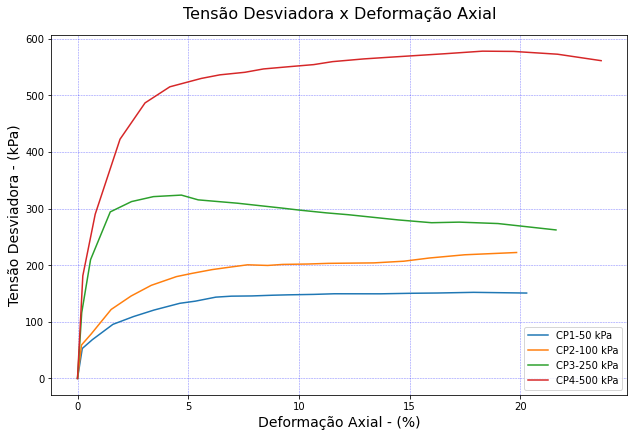

In [65]:
# Gráfico tensão desviadora x deformação axial
fig = plt.figure(figsize=(8,5))
eixo = fig.add_axes([0,0,1,1])
eixo.plot(cp1['Deform_axial_(%)'], cp1['Sigma_d_(kPa)'],label='CP1-50 kPa')
eixo.plot(cp2['Deform_axial_(%)'], cp2['Sigma_d_(kPa)'], label='CP2-100 kPa')
eixo.plot(cp3['Deform_axial_(%)'], cp3['Sigma_d_(kPa)'], label='CP3-250 kPa')
eixo.plot(cp4['Deform_axial_(%)'], cp4['Sigma_d_(kPa)'], label='CP4-500 kPa')
eixo.legend()
eixo.set_title('Tensão Desviadora x Deformação Axial', fontsize=16, pad=16)
eixo.set_ylabel('Tensão Desviadora - (kPa)', fontsize= 14)
eixo.set_xlabel('Deformação Axial - (%)', fontsize= 14)
plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)

### Gráfico Poropressão x Deformação Axial

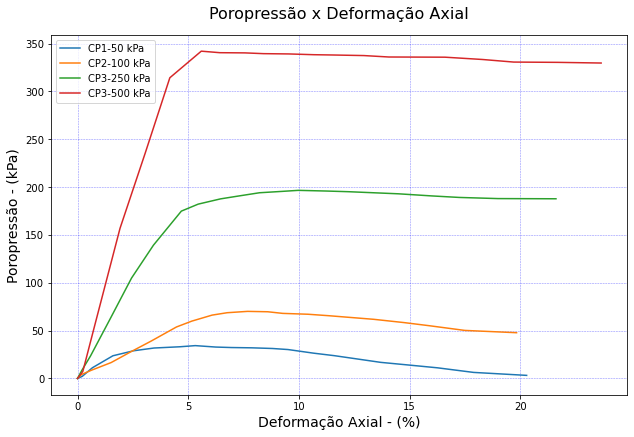

In [66]:
fig = plt.figure(figsize=(8,5))
eixo = fig.add_axes([0,0,1,1])
eixo.plot(cp1['Deform_axial_(%)'], cp1['Delta_U_(kPa)'],label='CP1-50 kPa')
eixo.plot(cp2['Deform_axial_(%)'], cp2['Delta_U_(kPa)'], label='CP2-100 kPa')
eixo.plot(cp3['Deform_axial_(%)'], cp3['Delta_U_(kPa)'], label='CP3-250 kPa')
eixo.plot(cp4['Deform_axial_(%)'], cp4['Delta_U_(kPa)'], label='CP3-500 kPa')
eixo.legend()
eixo.set_title('Poropressão x Deformação Axial', fontsize=16, pad=16)
eixo.set_ylabel('Poropressão - (kPa)', fontsize= 14)
eixo.set_xlabel('Deformação Axial - (%)', fontsize= 14)
plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)

### Gráfico Máxima Obliquidade x Deformação Axial

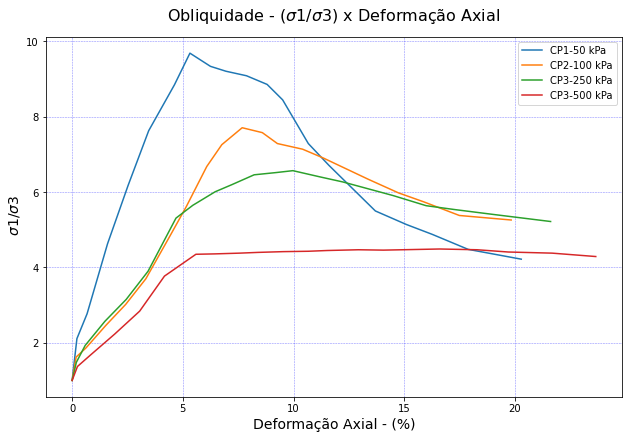

In [67]:
fig = plt.figure(figsize=(8,5))
eixo = fig.add_axes([0,0,1,1])
eixo.plot(cp1['Deform_axial_(%)'], cp1["Sigma'_1/Sigma'_3"],label='CP1-50 kPa')
eixo.plot(cp2['Deform_axial_(%)'], cp2["Sigma'_1/Sigma'_3"], label='CP2-100 kPa')
eixo.plot(cp3['Deform_axial_(%)'], cp3["Sigma'_1/Sigma'_3"], label='CP3-250 kPa')
eixo.plot(cp4['Deform_axial_(%)'], cp4["Sigma'_1/Sigma'_3"], label='CP4-500 kPa')
eixo.legend()
eixo.set_title('Obliquidade - ($\sigma1/\sigma3$) x Deformação Axial', fontsize=16, pad=16)
eixo.set_ylabel(' $\sigma1/\sigma3$', fontsize= 14)
eixo.set_xlabel('Deformação Axial - (%)', fontsize= 14)
plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)

### Trajetórias de Tensões e Parâmetros de Resistência - Máxima Tensão de Desvio

In [68]:
siglas = ['CP1 - 50 kPa','CP2-100 kPa','CP3-250 kPa','CP4-500 kPa']
Sigma_d_max = cp1['Sigma_d_(kPa)'].max()
data = {'Sigma_d_max': [cp1['Sigma_d_(kPa)'].max(),cp2['Sigma_d_(kPa)'].max(),cp3['Sigma_d_(kPa)'].max(),cp4['Sigma_d_(kPa)'].max()],
                       't': [cp1.loc[cp1['Sigma_d_(kPa)'].idxmax(), ['t'][0]],
                             cp2.loc[cp2['Sigma_d_(kPa)'].idxmax(), ['t'][0]],
                             cp3.loc[cp3['Sigma_d_(kPa)'].idxmax(), ['t'][0]],
                             cp4.loc[cp4['Sigma_d_(kPa)'].idxmax(), ['t'][0]]],
                       's': [cp1.loc[cp1['Sigma_d_(kPa)'].idxmax(), ['s'][0]],
                             cp2.loc[cp2['Sigma_d_(kPa)'].idxmax(), ['s'][0]],
                             cp3.loc[cp3['Sigma_d_(kPa)'].idxmax(), ['s'][0]],
                             cp4.loc[cp4['Sigma_d_(kPa)'].idxmax(), ['s'][0]]],
                       "s'":[cp1.loc[cp1['Sigma_d_(kPa)'].idxmax(), ["s'"][0]],
                             cp2.loc[cp2['Sigma_d_(kPa)'].idxmax(), ["s'"][0]],
                             cp3.loc[cp3['Sigma_d_(kPa)'].idxmax(), ["s'"][0]],
                             cp4.loc[cp4['Sigma_d_(kPa)'].idxmax(), ["s'"][0]]]}
                           
sigma_d_max = pd.DataFrame(data, index=siglas)

In [69]:
sigma_d_max.round(2)

,Sigma_d_max,t,s,s'
CP1 - 50 kPa,152.00,76.00,126.00,119.70
CP2-100 kPa,222.33,111.17,211.17,163.37
CP3-250 kPa,323.70,161.85,411.85,236.95
CP4-500 kPa,577.81,288.90,788.90,455.50


#### Envoltória de Tensões - Máxima Tensão de Desvio

Determinação da Envoltória (Regressão Linear Simples)

Utilizando a biblioteca estatística Statsmodels 

In [70]:
import statsmodels.api as sm

In [71]:
t = sigma_d_max['t']
s_linha = sm.add_constant(sigma_d_max["s'"])

D:\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [72]:
t.head()

CP1 - 50 kPa     75.9995
CP2-100 kPa     111.1665
CP3-250 kPa     161.8500
CP4-500 kPa     288.9030
Name: t, dtype: float64

In [73]:
s_linha.head()

,const,s'
CP1 - 50 kPa,1.0,119.6995
CP2-100 kPa,1.0,163.3665
CP3-250 kPa,1.0,236.9500
CP4-500 kPa,1.0,455.5030


Calculando a envoltória

In [74]:
envoltoria_regressao = sm.OLS(t,s_linha,missing='drop').fit()

Parâmetros da envoltória de regressão

Intercepto `(a)` e declividade da envoltoria `tan_alpha`

In [75]:
a = envoltoria_regressao.params[0]
a

7.349867044075026

In [76]:
tan_alpha = envoltoria_regressao.params[1]
tan_alpha

0.6237905482350419

#### Coeficiente de determinação (R²)

In [77]:
R_2 = envoltoria_regressao.rsquared
print(f'O coeficiente de determinação R_2 = {R_2:.3f}')

O coeficiente de determinação R_2 = 0.996


In [78]:
# 0 -> é o limite inferior do intervalo 
# 1 -> é o limite superior do intervalo.

envoltoria_regressao.conf_int(alpha=0.05) 

,0,1
const,-23.713259,38.412993
s',0.511232,0.736349


In [79]:
# Envoltória de Regressão

#t = 7.349867 +  0.623791 * s_linha

sigma_d_max['t_Previsto'] = envoltoria_regressao.predict()

In [80]:
sigma_d_max

,Sigma_d_max,t,s,s',t_Previsto
CP1 - 50 kPa,151.999,75.9995,125.9995,119.6995,82.017284
CP2-100 kPa,222.333,111.1665,211.1665,163.3665,109.256346
CP3-250 kPa,323.700,161.8500,411.8500,236.9500,155.157037
CP4-500 kPa,577.806,288.9030,788.9030,455.5030,291.488333


#### Parâmetros de Resistência - Máxima Tensão Desviadora

In [81]:
parametros_sigma_d_max =  {'tan_alpha': [tan_alpha],'sen_phi_linha':[tan_alpha],'phi_linha': [np.arcsin(tan_alpha)*(180/(np.pi))],'cos_phi_linha': [np.cos(np.arcsin(tan_alpha)*(180/(np.pi))*(np.pi/180))],'a': a, "c": a/[np.cos(np.arcsin(tan_alpha)*(180/(np.pi))*(np.pi/180))]}

parametros_max_desvio = pd.DataFrame(parametros_sigma_d_max).round(1)
parametros_max_desvio

,tan_alpha,sen_phi_linha,phi_linha,cos_phi_linha,a,c
0,0.6,0.6,38.6,0.8,7.3,9.4


In [82]:
parametros_max_desvio.rename(index={0:'Parâmetros de Resistência'}, inplace=True)
parametros_max_desvio.T

,Parâmetros de Resistência
tan_alpha,0.6
sen_phi_linha,0.6
phi_linha,38.6
cos_phi_linha,0.8
a,7.3
c,9.4


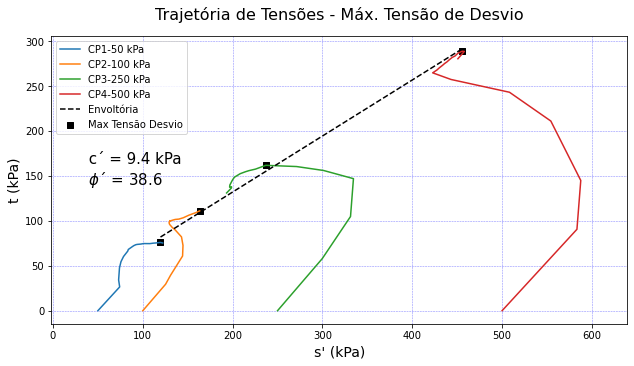

In [83]:
fig = plt.figure(figsize=(8,5))
eixo = fig.add_axes([0,0,1,0.8])

c, phi_linha = parametros_max_desvio['c'], parametros_max_desvio['phi_linha']

eixo.plot(cp1["s'"], cp1["t"],label='CP1-50 kPa')
eixo.plot(cp2["s'"], cp2['t'], label='CP2-100 kPa')
eixo.plot(cp3["s'"], cp3['t'], label='CP3-250 kPa')
eixo.plot(cp4["s'"], cp4['t'], label='CP4-500 kPa')
plt.scatter(sigma_d_max["s'"],sigma_d_max['t'], label='Max Tensão Desvio', marker='s', s=40, color='k')
eixo.plot(sigma_d_max["s'"],sigma_d_max['t_Previsto'],label='Envoltória', color='k', ls='--')

eixo.annotate(f' c´ = {c[0]} kPa\n $\phi´$ = {phi_linha[0]}', xy=(35,140), fontsize=15)                                                    
eixo.set_title('Trajetória de Tensões - Máx. Tensão de Desvio', fontsize=16, pad=16)
eixo.set_ylabel('t (kPa)', fontsize= 14)
eixo.set_xlabel("s' (kPa)", fontsize= 14)
plt.legend(loc='best')
plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.axis('equal')
plt.show()


### Envoltória de Tensões - Máxima Obliquidade

Determinação da Envoltória (Regressão Linear Simples)

Utilizando a biblioteca estatística Statsmodels 

#### Selecionando as linhas com máximo `Sigma'_1/Sigma'_3` dos dataframes correspondentes a cada corpo de prova

In [84]:
a = cp1[cp1["Sigma'_1/Sigma'_3"] == cp1["Sigma'_1/Sigma'_3"].max()]
a

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
7,5.32,34.3,136.422,50,186.422,152.122,15.7,9.69,68.211,118.211,83.911,136.422,95.474,61.174


In [85]:
b = cp2[cp2["Sigma'_1/Sigma'_3"] == cp2["Sigma'_1/Sigma'_3"].max()]
b

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
10,7.68,70.1,200.633,100,300.633,230.533,29.9,7.71,100.3165,200.3165,130.2165,200.633,166.877667,96.777667


In [86]:
c = cp3[cp3["Sigma'_1/Sigma'_3"] == cp3["Sigma'_1/Sigma'_3"].max()]
c

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
12,9.97,196.6,297.41,250,547.41,350.81,53.4,6.57,148.705,398.705,202.105,297.41,349.136667,152.536667


In [87]:
d = cp4[cp4["Sigma'_1/Sigma'_3"] == cp4["Sigma'_1/Sigma'_3"].max()]
d

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
15,16.6,335.8,573.297,500,1073.297,737.497,164.2,4.49,286.6485,786.6485,450.8485,573.297,691.099,355.299


#### Preparando o Dataframe com os dados da máxima obliquidade

In [88]:
siglas = ['CP1 - 50 kPa','CP2-100 kPa','CP3-250 kPa','CP4-500 kPa']
data = {"Sig'_1/Sig'_3_Max": [cp1["Sigma'_1/Sigma'_3"].max(),cp2["Sigma'_1/Sigma'_3"].max(),cp3["Sigma'_1/Sigma'_3"].max(),cp4["Sigma'_1/Sigma'_3"].max()],
                       't': [cp1.loc[cp1["Sigma'_1/Sigma'_3"].idxmax(), ['t'][0]],
                             cp2.loc[cp2["Sigma'_1/Sigma'_3"].idxmax(), ['t'][0]],
                             cp3.loc[cp3["Sigma'_1/Sigma'_3"].idxmax(), ['t'][0]],
                             cp4.loc[cp4["Sigma'_1/Sigma'_3"].idxmax(), ['t'][0]]],
                       's': [cp1.loc[cp1["Sigma'_1/Sigma'_3"].idxmax(), ['s'][0]],
                             cp2.loc[cp2["Sigma'_1/Sigma'_3"].idxmax(), ['s'][0]],
                             cp3.loc[cp3["Sigma'_1/Sigma'_3"].idxmax(), ['s'][0]],
                             cp4.loc[cp4["Sigma'_1/Sigma'_3"].idxmax(), ['s'][0]]],
                       "s'":[cp1.loc[cp1["Sigma'_1/Sigma'_3"].idxmax(), ["s'"][0]],
                             cp2.loc[cp2["Sigma'_1/Sigma'_3"].idxmax(), ["s'"][0]],
                             cp3.loc[cp3["Sigma'_1/Sigma'_3"].idxmax(), ["s'"][0]],
                             cp4.loc[cp4["Sigma'_1/Sigma'_3"].idxmax(), ["s'"][0]]]}

sigma_1_sigma_3 = pd.DataFrame(data, index=siglas)

In [89]:
sigma_1_sigma_3

,Sig'_1/Sig'_3_Max,t,s,s'
CP1 - 50 kPa,9.69,68.2110,118.2110,83.9110
CP2-100 kPa,7.71,100.3165,200.3165,130.2165
CP3-250 kPa,6.57,148.7050,398.7050,202.1050
CP4-500 kPa,4.49,286.6485,786.6485,450.8485


Envoltória

In [90]:
t = sigma_1_sigma_3['t']
s_linha = sm.add_constant(sigma_1_sigma_3["s'"])

D:\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [91]:
t.head()

CP1 - 50 kPa     68.2110
CP2-100 kPa     100.3165
CP3-250 kPa     148.7050
CP4-500 kPa     286.6485
Name: t, dtype: float64

In [92]:
s_linha.head()

,const,s'
CP1 - 50 kPa,1.0,83.9110
CP2-100 kPa,1.0,130.2165
CP3-250 kPa,1.0,202.1050
CP4-500 kPa,1.0,450.8485


In [93]:
envoltoria_regressao = sm.OLS(t,s_linha,missing='drop').fit()

Parâmetros da envoltória de regressão

Intercepto `(a)` e declividade da envoltoria `tan_alpha`

In [94]:
a = envoltoria_regressao.params[0]
a

23.39179214103204

In [95]:
tan_alpha = envoltoria_regressao.params[1]
tan_alpha

0.5885422831729356

#### Coeficiente de determinação (R²)

In [96]:
R_2 = envoltoria_regressao.rsquared
print(f'O coeficiente de determinação R_2 = {R_2:.3f}')

O coeficiente de determinação R_2 = 0.998


In [97]:
# Intervalo de Confiança
# 0 -> é o limite inferior do intervalo 
# 1 -> é o limite superior do intervalo.

envoltoria_regressao.conf_int(alpha=0.05) 

,0,1
const,0.821635,45.961949
s',0.501364,0.675721


In [98]:
# Envoltória de Regressão

#t = 23.392 +  0.5885 * s_linha

sigma_1_sigma_3['t_Previsto'] = envoltoria_regressao.predict()

In [99]:
 sigma_1_sigma_3

,Sig'_1/Sig'_3_Max,t,s,s',t_Previsto
CP1 - 50 kPa,9.69,68.2110,118.2110,83.9110,72.776964
CP2-100 kPa,7.71,100.3165,200.3165,130.2165,100.029708
CP3-250 kPa,6.57,148.7050,398.7050,202.1050,142.339130
CP4-500 kPa,4.49,286.6485,786.6485,450.8485,288.735198


#### Parâmetros de Resistência - Máxima Obliquidade

In [100]:
parametros_sigma_1_sigma_3_max =  {'tan_alpha': [tan_alpha],'sen_phi_linha':[tan_alpha],'phi_linha': [np.arcsin(tan_alpha)*(180/(np.pi))],'cos_phi_linha': [np.cos(np.arcsin(tan_alpha)*(180/(np.pi))*(np.pi/180))],'a': a, "c": a/[np.cos(np.arcsin(tan_alpha)*(180/(np.pi))*(np.pi/180))]}

parametros_sigma_1_sigma_3_max  = pd.DataFrame(parametros_sigma_1_sigma_3_max ).round(3)
parametros_sigma_1_sigma_3_max 

,tan_alpha,sen_phi_linha,phi_linha,cos_phi_linha,a,c
0,0.589,0.589,36.054,0.808,23.392,28.934


In [101]:
parametros_sigma_1_sigma_3_max.rename(index={0:'Parâmetros de Resistência'}, inplace=True)
parametros_sigma_1_sigma_3_max.T

,Parâmetros de Resistência
tan_alpha,0.589
sen_phi_linha,0.589
phi_linha,36.054
cos_phi_linha,0.808
a,23.392
c,28.934


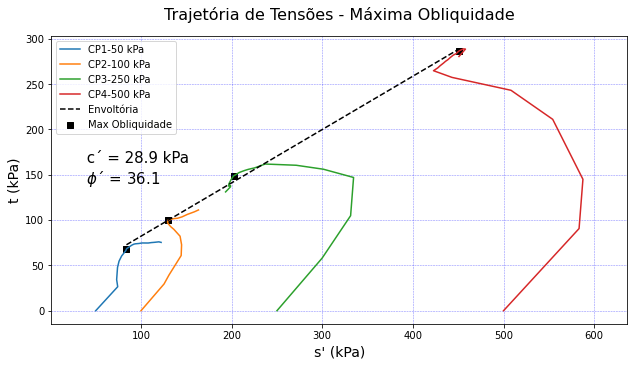

In [102]:
fig = plt.figure(figsize=(8,5))
eixo = fig.add_axes([0,0,1,0.8])

c, phi_linha = parametros_sigma_1_sigma_3_max['c'].round(1), parametros_sigma_1_sigma_3_max['phi_linha'].round(1)

eixo.plot(cp1["s'"], cp1["t"],label='CP1-50 kPa')
eixo.plot(cp2["s'"], cp2['t'], label='CP2-100 kPa')
eixo.plot(cp3["s'"], cp3['t'], label='CP3-250 kPa')
eixo.plot(cp4["s'"], cp4['t'], label='CP4-500 kPa')
plt.scatter(sigma_1_sigma_3["s'"],sigma_1_sigma_3['t'], label='Max Obliquidade', marker='s', s=40, color='k')
eixo.plot(sigma_1_sigma_3["s'"],sigma_1_sigma_3['t_Previsto'],label='Envoltória', color='k', ls='--')

eixo.annotate(f' c´ = {c[0]} kPa\n $\phi´$ = {phi_linha[0]}', xy=(35,140), fontsize=15)                                                    
eixo.set_title('Trajetória de Tensões - Máxima Obliquidade', fontsize=16, pad=16)
eixo.set_ylabel('t (kPa)', fontsize= 14)
eixo.set_xlabel("s' (kPa)", fontsize= 14)
plt.legend(loc='best')
plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.axis('equal')
plt.show()

### CÍRCULO DE MOHR

#### Selecionando  a linha de Máxima Tensão Desviadora para cada cp

In [103]:
a = cp1[cp1["Sigma_d_(kPa)"] == cp1["Sigma_d_(kPa)"].max()]

In [104]:
a

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
18,17.888,6.3,151.999,50,201.999,195.699,43.7,4.48,75.9995,125.9995,119.6995,151.999,100.666333,94.366333


In [105]:
b = cp2[cp2["Sigma_d_(kPa)"] == cp2["Sigma_d_(kPa)"].max()]

In [106]:
b

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
19,19.83,47.8,222.333,100,322.333,274.533,52.2,5.26,111.1665,211.1665,163.3665,222.333,174.111,126.311


In [107]:
c = cp3[cp3["Sigma_d_(kPa)"] == cp3["Sigma_d_(kPa)"].max()]

In [108]:
c

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
6,4.69,174.9,323.7,250,573.7,398.8,75.1,5.31,161.85,411.85,236.95,323.7,357.9,183.0


In [109]:
d = cp4[cp4["Sigma_d_(kPa)"] == cp4["Sigma_d_(kPa)"].max()]

In [110]:
d

,Deform_axial_(%),Delta_U_(kPa),Sigma_d_(kPa),Sigma_3_(kPa),Sigma_1_(kPa),Sigma'_1_(kPa),Sigma3'_(kPa),Sigma'_1/Sigma'_3,t,s,s',q,p,p'
16,18.29,333.4,577.806,500,1077.806,744.406,166.6,4.47,288.903,788.903,455.503,577.806,692.602,359.202


In [111]:
siglas = ['CP1 - 50 kPa','CP2-100 kPa','CP3-250 kPa','CP4-500 kPa']
data = {'sig_1': [a["Sigma'_1_(kPa)"].max(),b["Sigma'_1_(kPa)"].max(),c["Sigma'_1_(kPa)"].max(),d["Sigma'_1_(kPa)"].max()],
        'sig_3': [a["Sigma3'_(kPa)"].max(),b["Sigma3'_(kPa)"].max(),c["Sigma3'_(kPa)"].max(),d["Sigma3'_(kPa)"].max()]}
circulos = pd.DataFrame(data=data, index=siglas)    

circulos['Raio_(i)'] = (circulos['sig_1'] - circulos['sig_3'])/2

In [112]:
circulos['Centro_(x_i)'] = (circulos['sig_1'] + circulos['sig_3'])/2

In [113]:
circulos

,sig_1,sig_3,Raio_(i),Centro_(x_i)
CP1 - 50 kPa,195.699,43.7,75.9995,119.6995
CP2-100 kPa,274.533,52.2,111.1665,163.3665
CP3-250 kPa,398.800,75.1,161.8500,236.9500
CP4-500 kPa,744.406,166.6,288.9030,455.5030


#### Traçado da Envoltória de Mohr-Coulomb

Para o traçado da envoltória forneça os valores de  `c (coesão) e phi (ângulo de atrito)` até ajustar a envoltória 
aos círculos de Mohr.

Forneça também o valor de `sig` para ajustar a envoltória no intervalo de tensões do ensaio.

Valores de c e sig em kPa e phi em graus.


In [114]:
c = 13.5
phi =  37.7
sig = 400

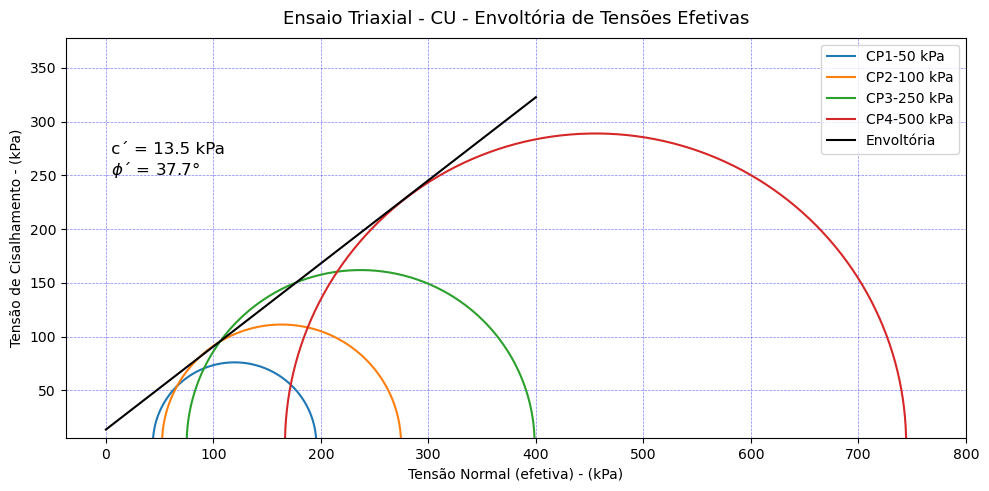

In [115]:
fig = plt.figure(figsize=(15,8), dpi=100)
ax = fig.add_axes([0,0.1,0.6,0.5])
#PARÂMETROS DO CÍRCULOS
x0, r = circulos['Centro_(x_i)'].loc['CP1 - 50 kPa'],circulos['Raio_(i)'].loc['CP1 - 50 kPa']
x1, r1 = circulos['Centro_(x_i)'].loc['CP2-100 kPa'],circulos['Raio_(i)'].loc['CP2-100 kPa']
x2, r2 = circulos['Centro_(x_i)'].loc['CP3-250 kPa'],circulos['Raio_(i)'].loc['CP3-250 kPa']
x3, r3 = circulos['Centro_(x_i)'].loc['CP4-500 kPa'],circulos['Raio_(i)'].loc['CP4-500 kPa']
#EQUAÇÕES PARAMÉTRICAS DO CÍRCULO
t = np.arange(0,np.pi, 0.01)
x = x0 + r * np.cos(t)
y = r * np.sin(t)
x1 = x1 + r1 * np.cos(t)
y1 = r1 * np.sin(t)
x2 = x2 + r2 * np.cos(t)
y2 = r2 * np.sin(t)
x3 = x3 + r3 * np.cos(t)
y3 = r3 * np.sin(t)

#PLOTAGEM DOS CÍRCULOS
ax.plot(x,y, label='CP1-50 kPa')
ax.plot(x1,y1, label='CP2-100 kPa')
ax.plot(x2,y2, label='CP3-250 kPa')
ax.plot(x3,y3, label='CP4-500 kPa')
# CALCULANDO A ENVOLTÓRIA DE TENSÕES 
c = c
phi = phi*(np.pi/180)
sig = sig
tau = c + sig * np.tan(phi)
x3= [0,sig]
x4= [0,sig]
y4= [c,tau]
ax.plot(x4,y4,'k-', label="Envoltória")

#ADICIONANDO LEGENDA, GRID E AJUSTANDO ESCALAS IGUAIS NOS EIXOS X e Y
ax.legend(loc='best')
plt.axis('equal')
xticks = [0,100,200,300,400,500,600,700,800]
yticks = [0,50,100,150,200,250,300,350,400]
ax.set_xticks(xticks)
ax.set_yticks(yticks)
plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
#ADICIONANDO TEXTO 
#ax.plot(c', phi)
#ax.text(0,90, r'c = 17 kPa', fontsize=12,color="black")
#ax.text(0,80, r'$\phi$ = 35°', fontsize=12, color="black")
ax.annotate(f' c´ = {c} kPa\n $\phi´$ = {phi*180/np.pi}°', xy=(0,250), fontsize=12)   

#ADICIONANDO TÍTULOS DO GRÁFICO E DOS EIXOS
ax.set_xlabel('Tensão Normal (efetiva) - (kPa)')
ax.set_ylabel('Tensão de Cisalhamento - (kPa)')
ax.set_title('Ensaio Triaxial - CU - Envoltória de Tensões Efetivas', fontsize=13, pad=10)
plt.show()